# Pythonによる画像解析ノート Vol. 4

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imageio
from PIL import Image as pilimage
from IPython.display import display, Image

# Jupyter notebookの中で画像を表示させるための関数、読み込んだ画像が16-bitならば画像を8bitに変換するように修正
def show(img_grey):
    if img_grey.dtype == "uint16":
        img_grey = cv2.normalize(img_grey, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    _, buf = cv2.imencode(".jpg", img_grey)
    print(type(buf))
    print(buf.shape)
    display(Image(data = buf.tobytes()))

## Watershedアルゴリズムを使った画像の領域分割
検出した対象が重なっている = 同じブロブとしてラベルされる場合に利用する、マーカーベースの領域分割。  
確実に背景あるいは前景と言える領域に異なるラベルを与える。これをマーカーとして、watershedアルゴリズムを適用。  
設定したマーカはラベルの値と共に更新され、境界領域に画素の値は―1になる。  
http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_imgproc/py_watershed/py_watershed.html   

距離変換は例えばerosionを1回して消去された画素の距離を1、2回目で消去された画素の距離を2とした場合、最後に残る「核」の距離が一番大きくなる。  
なので距離とは対象と背景の境界から、核までの距離に他ならない。

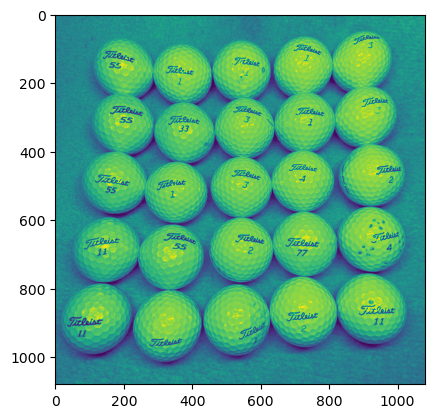

In [2]:
gb = cv2.imread("images/golf_balls.jpg", 0)
plt.imshow(gb)

(array([ 10161.,   8014.,  10533.,  14588.,  18802.,  26340.,  35935.,
         62082., 116582., 150841., 113687.,  52184.,  54307.,  88153.,
        117868., 155328., 104567.,  18500.,   4873.,   3055.]),
 array([  0. ,  12.8,  25.6,  38.4,  51.2,  64. ,  76.8,  89.6, 102.4,
        115.2, 128. , 140.8, 153.6, 166.4, 179.2, 192. , 204.8, 217.6,
        230.4, 243.2, 256. ]),
 <BarContainer object of 20 artists>)

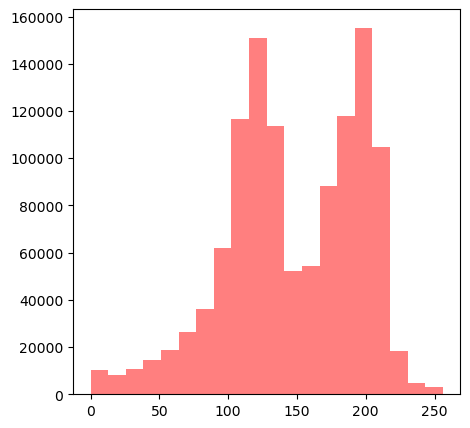

In [3]:
plt.figure(figsize=(5,5))
plt.hist(gb.ravel(), bins = 20, range = [0, 256], color=(1,0,0), alpha = 0.5) # ravel()で1次元配列に戻す

148.0


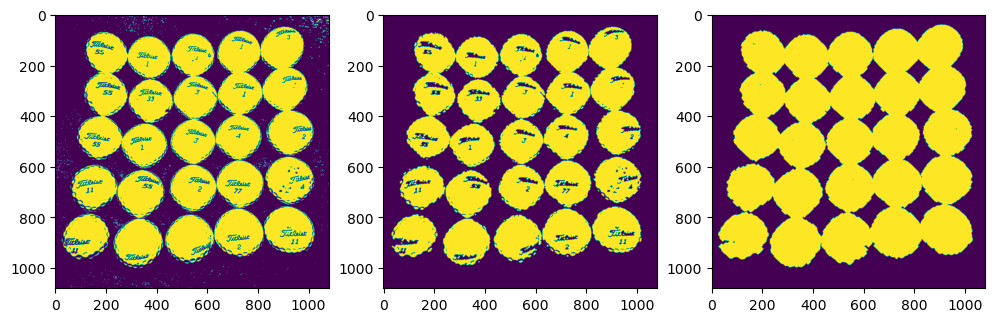

In [4]:
# Otsu法で2値化処理
ret, gb_bin = cv2.threshold(gb, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print(ret)

# ノイズをできる限り除去
from scipy import ndimage
gb_open = ndimage.binary_opening(gb_bin, iterations=3).astype(int)
gb_close = ndimage.binary_dilation(gb_open, iterations=9).astype(int)
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(gb_bin)
plt.subplot(1,3,2)
plt.imshow(gb_open)
plt.subplot(1,3,3)
plt.imshow(gb_close)

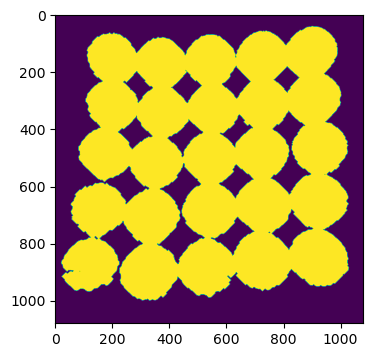

In [5]:
# 確実に背景である領域を求める
# 対象（白）の領域を膨張させるということは、残った黒の背景は「確実に背景」
sure_bg = ndimage.binary_dilation(gb_close, iterations= 2).astype(gb_close.dtype)
plt.figure(figsize=(4,4))
plt.imshow(sure_bg)

距離変換で得られた値の最小値と最大値: 0.0 94.29458
閾値（距離変換で得られた値の最大値×0.5）: 148.0


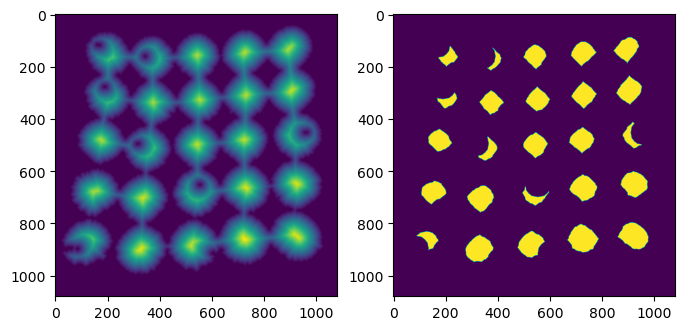

In [6]:
# Finding sure foreground area
# 対象物が互いに接していなければ erosionして残った白い領域は確実に前景と言える
# 対象物が互いに接している場合、Euclidian Distance Map (EDM)を計算し、距離変換で得られた値の最大値✕0.5（可変）を閾値にして二値化することで、「確実な前景」が得られる
gb_close = gb_close.astype("uint8")
dist_transform = cv2.distanceTransform(gb_close, cv2.DIST_L2,5)
print("距離変換で得られた値の最小値と最大値:", dist_transform.min(), dist_transform.max())
print('閾値（距離変換で得られた値の最大値×0.5）:',dist_transform.max()*0.5)
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.imshow(dist_transform)
plt.subplot(1,2,2)
plt.imshow(sure_fg)

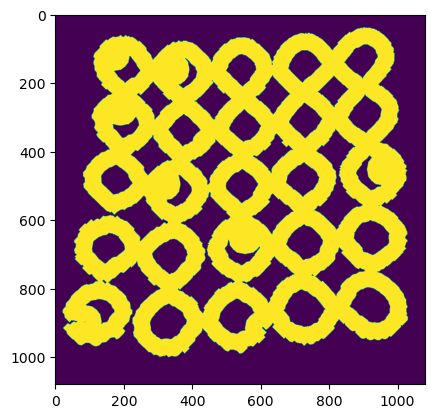

In [7]:
# Finding unknown region
# 背景でも前景でもないunknownな領域の情報」を取得
# 「絶対に背景」から「絶対に前景」の情報を引く
sure_fg = np.uint8(sure_fg)
sure_bg = np.uint8(sure_bg)
unknown = cv2.subtract(sure_bg, sure_fg)
plt.imshow(unknown*255)

In [8]:
"""
Marker labelling
1. 明確な背景（sure background）情報
2. 明確な前景(sure foreground)情報
3. 背景でも前景でもないunknownな領域の情報
4. 1~3の情報に"ラベル"をつける
ｃｖ2.connectedComponents関数は画像の背景に0というラベルを与え，それ以外の物体に対して1から順にラベルをつけていく処理をする．
"""
ret, markers = cv2.connectedComponents(sure_fg)
# この時点での背景のピクセル値 -> 0、各オブジェクトのピクセル値 -> 1,2,...,37

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# この時点での背景のピクセル値 -> 1、各オブジェクトのピクセル値 -> 2,3,...,38

# # Now, mark the region of unknown with zero
# unknownのピクセル値を0にする
markers[unknown == 1] = 0 # boolean indexing
# この時点での背景のピクセル値 -> 1、各オブジェクトのピクセル値 -> 2,3,...,38, unknownのピクセル値 -> 0

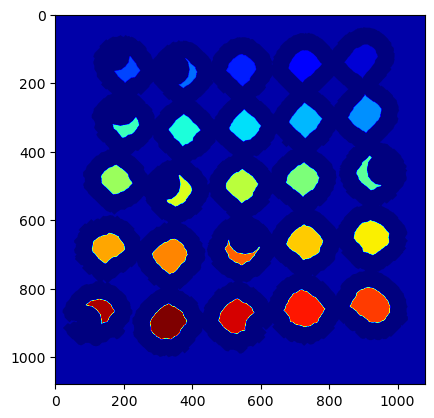

In [9]:
plt.imshow(markers, cmap = "jet")

26


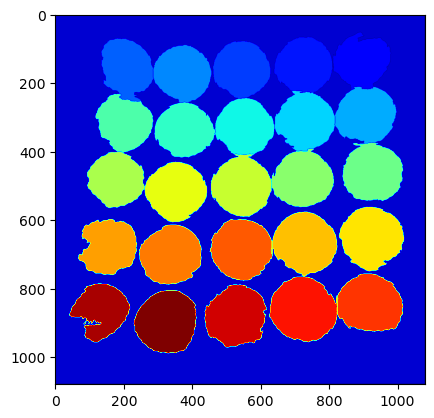

In [43]:
# Watershed関数による処理
# markersの情報を元に処理
# markersのラベルは更新され、境界領域のピクセル値は-1になる
gb_rgb = cv2.imread("images/golf_balls.jpg", 1)
markers = cv2.watershed(gb_rgb, markers) # imgはRGBである必要がある
# この時点での背景のピクセル値 -> 1、境界領域 -> -1, 各オブジェクト -> 2,3,...,38,
plt.imshow(markers, cmap = "jet")
print(markers.max())

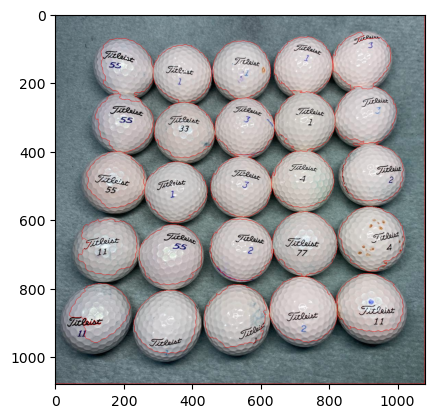

In [11]:
# 境界領域を赤色にする
gb_rgb_segm = gb_rgb.copy()
gb_rgb_segm[markers == -1] = (255, 0, 0)
plt.imshow(gb_rgb_segm)

### skimageのライブラリを使用する場合  
`skimage.segmentation.watershed()関数`  
Euclidian Distance Map (EDM)のLocal maximaを最初のマーカーとする。  
local maximaを求める`peak_local_max()`関数ではしきい値を設定できるので、それによりmaximaの数は異なる。  
maximaが多くなるほど、最終的な分割も多くなるはず。

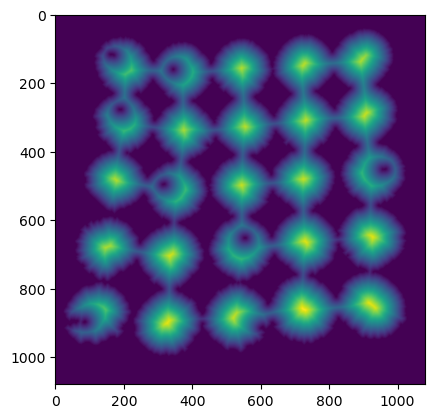

In [12]:
from skimage import segmentation
from skimage.feature import peak_local_max
from skimage import io, img_as_float, img_as_ubyte
from scipy import ndimage as ndi
distance = ndi.distance_transform_edt(gb_close)
plt.imshow(distance)

In [13]:
# local maximaの座標を得る
max_coords = peak_local_max(distance, labels=gb_close, min_distance=1, threshold_abs = 50, # threshold_absがmaximaのしきい値
                            footprint=np.ones((30, 30))) # footprintの大きさでもmaximaの数は変化する
local_maxima = np.zeros_like(gb_close, dtype=bool)
local_maxima[tuple(max_coords.T)] = True
markers2 = ndi.label(local_maxima)[0]

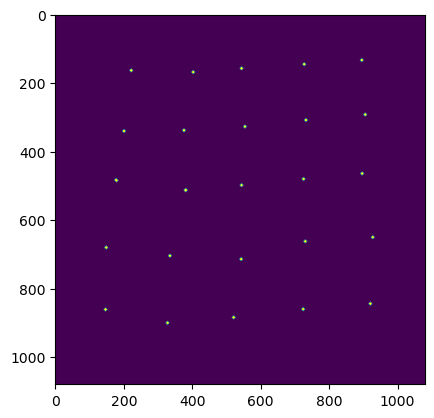

In [14]:
# local maximaを拡大して表示
local_maxima_dia= ndimage.binary_dilation(local_maxima, iterations= 5).astype(local_maxima.dtype)
plt.imshow(img_as_ubyte(local_maxima_dia))

26

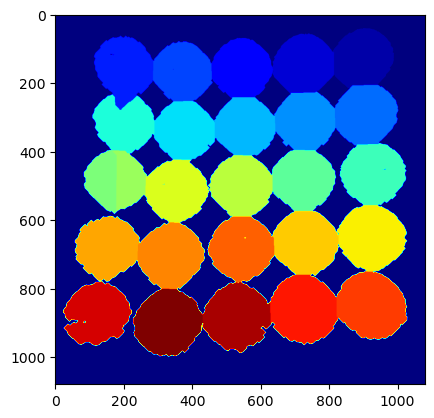

In [46]:
labels = segmentation.watershed(-distance, markers2, mask=gb_close)
plt.imshow(labels, cmap = "jet")
labels.max()

後述の`skimage.morphology.h_maxima()`関数は座標ではなくmaximaの2値画像を返すので、処理がより簡単になる

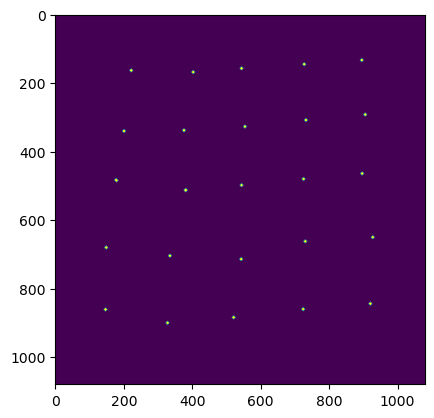

In [54]:
from skimage.morphology import h_maxima
distance = ndi.distance_transform_edt(gb_close)
h = 5
local_maxima_img = h_maxima(distance, h, footprint=np.ones((3, 3)))
local_maxima_img_dia= ndimage.binary_dilation(local_maxima_img, iterations= 5).astype(local_maxima_img.dtype)
plt.imshow(local_maxima_img_dia)

26

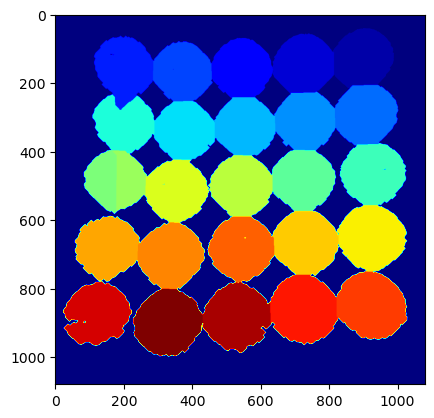

In [55]:
markers3 = ndi.label(local_maxima_img)[0]
labels2 = segmentation.watershed(-distance, markers3, mask=gb_close)
plt.imshow(labels2, cmap = "jet")
labels2.max()

## 検出した対象の解析  
ラベルした対象（ブロブ）について面積等を計測する。ImageJ/FIJIの`Measure`コマンドに対応。  
また元の画像を測定対象とすることで、輝度に関する情報も得られる。 これはImageJ/FIJIにおいて、検出したROIを元画像に重ねて測定することに対応する。 

返り値は各領域のprpertiesであるregionpropertiesオブジェクトのリスト。  
ラベルの値は計算に使用したラベル画像に準拠する。

In [19]:
from skimage import data, util
from skimage.measure import label, regionprops
gb_rgb = cv2.imread("images/golf_balls.jpg", 1)
props = regionprops(markers, intensity_image=gb_rgb)

In [20]:
len(props) # 上のラベル画像markersでは1が背景に相当するので、実際の対象は25個

26

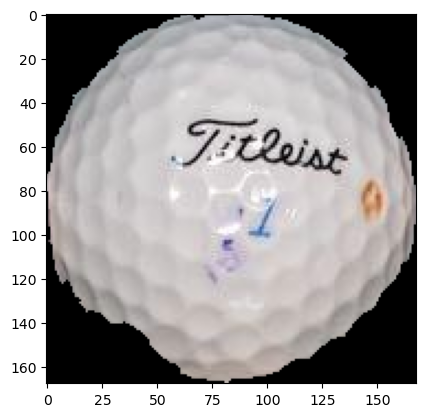

In [21]:
prop4 = props[3]
plt.imshow(prop4.image_intensity)

In [22]:
print(f"Label: {prop4.label}, Area: {prop4.area}, Mean intensity: {prop4.intensity_mean}, Centroid weighted local: {prop4.centroid_weighted_local}, Perimeter: {prop4.perimeter}")

Label: 4, Area: 21399, Mean intensity: [192.934296   187.99654189 188.20921538], Centroid weighted local: [[81.83846732 81.2574944  80.90534102]
 [83.58220182 83.31450771 83.18375395]], Perimeter: 575.7422074112307


`skimage.measure.regionprops_table()`関数を使うと測定結果が辞書形式で返ってくる。Pandasのデータフレームで読み込めるので効率的。  
引数propertiesで測定項目を指定する。引数extra_propertiesで独自の測定項目を計算する関数を入力することも可能。

In [23]:
from skimage.measure import label, regionprops_table
prop_dic = regionprops_table(markers, intensity_image=gb_rgb, properties=["label", "area", "image_intensity", "intensity_mean", "perimeter", "solidity", "feret_diameter_max"])
data = pd.DataFrame(prop_dic)

In [24]:
data.head()

,label,area,image_intensity,intensity_mean-0,intensity_mean-1,intensity_mean-2,perimeter,solidity,feret_diameter_max
0,1,574397,"[[[99, 116, 125], [96, 113, 122], [95, 112, 12...",95.693653,109.928614,113.196404,19106.479246,0.494282,1523.815278
1,2,19727,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",208.995184,198.994829,199.934506,686.109740,0.918945,178.709261
2,3,21222,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",202.528131,193.362595,193.301762,603.848809,0.966746,173.761331
3,4,21399,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",192.934296,187.996542,188.209215,575.742207,0.974320,170.792271
4,5,20608,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",179.791392,177.135627,182.278241,678.488419,0.929754,199.922485


<class 'numpy.ndarray'>
(11275,)


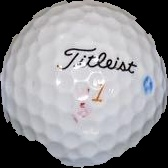

In [25]:
show(data.iloc[3, 2])  # 画像ごと保存できる

## 極大点の検出  
ImageJ/FIJIの`FindMaxima`関数に対応。  周囲と比較して`h`以上のピクセル値を持つ極大点を抽出し、座標の画素が1となった2値画像を返す。  
極小値版の関数も存在。似たような関数に`extrema.local_maxima()`があるので注意。

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


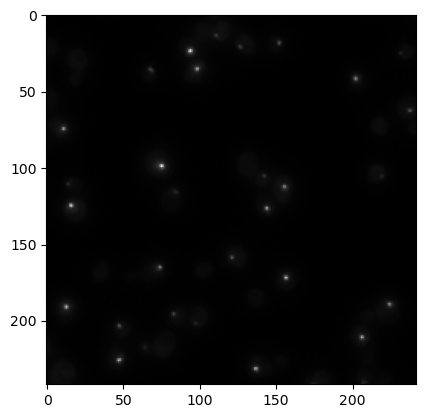

In [26]:
from skimage.measure import label
from skimage import data
from skimage import color
from skimage.morphology import extrema
from skimage import exposure
from skimage import io, img_as_float, img_as_ubyte
foci = io.imread("images/foci.tif", as_gray= True)
plt.imshow(foci, cmap = "gray")

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 3.9839e+04, 9.4320e+03,
        3.2650e+03, 2.4770e+03, 1.6470e+03, 7.9700e+02, 3.2000e+02,
        1.4800e+02, 1.1600e+02, 8.4000e+01, 6.8000e+01, 6.0000e+01,
        3.3000e+01, 2.8000e+01, 2.5000e+01, 2.8000e+01, 1.8000e+01,
        1.3000e+01, 1.2000e+01, 1.6000e+01, 8.0000e+00, 9.0000e+00,
        6.0000e+00, 6.0000e+00, 7.0000e+00, 5.0000e+00, 4.0000e+00,
        4.0000e+00, 5.0000e+00, 3.0000e+00, 7.0000e+00, 6.0000e+00,
        3.0000e+00, 3.0000e+00, 6.0000e+00, 1.0000e+00, 1.0000e+00,
        3.0000e+00, 2.0000e+00, 0.0000e+00, 3.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 2.0000e+00, 4.0000e+00, 6.0000e+00,
        3.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 1.0000e+00, 3.0000e+00, 3.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 2.0000e+00, 1.0000e+00, 1.00

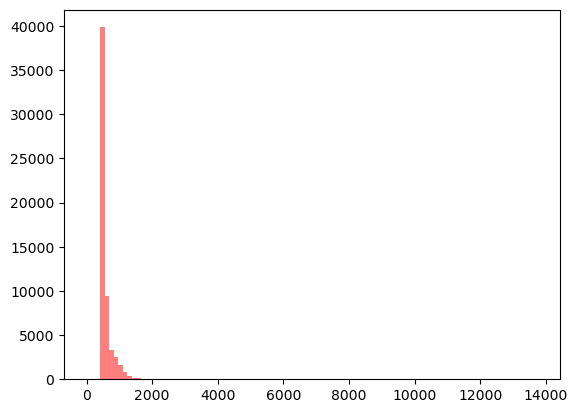

In [27]:
plt.hist(foci.ravel(), bins = 100, range = [0, foci.max()], color=(1,0,0), alpha = 0.5) # ravel()で1次元配列に戻す

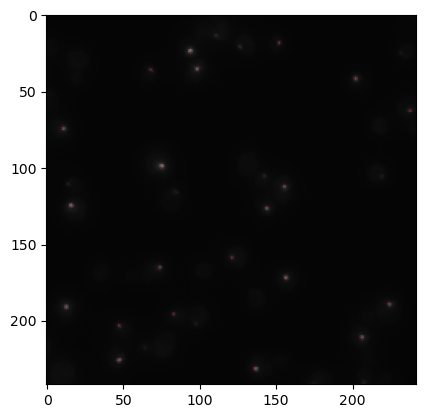

In [28]:
h = 3000
h_maxima = extrema.h_maxima(foci, h, footprint=None)
label_h_maxima = label(h_maxima)
overlay_h = color.label2rgb(label_h_maxima, foci*3, alpha=0.7, bg_label=0,
                          bg_color=None, colors=[(1, 0, 0)])
plt.imshow(overlay_h)

検出した極大点は1画素であり、ラベルとして小さい場合は、dialation処理で大きくする  
大きくしたラベル画像を使用して、極大点の平均ピクセル値を測定できる。

In [29]:
from scipy import ndimage
h_maxima_dia2= ndimage.binary_dilation(h_maxima, iterations= 2).astype(h_maxima.dtype)

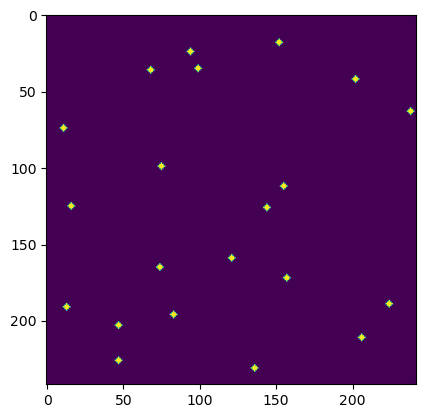

In [30]:
plt.imshow(h_maxima_dia2)

nd.binary_dilation()を使うとダイヤ型に膨張する。  
四角や丸のラベルを作りたい場合は`skimage.morphology.dilation`でfootprintを指定する

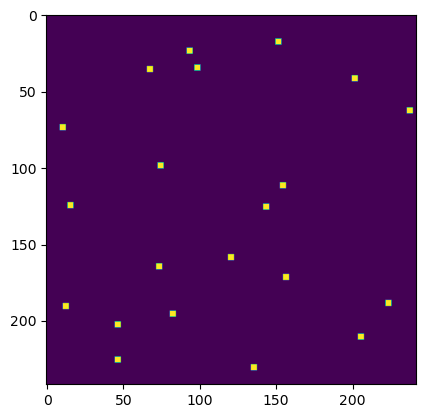

In [31]:
from skimage import morphology
h_maxima2 = morphology.binary_dilation(h_maxima, footprint=np.ones((4,4)))
plt.imshow(h_maxima2)

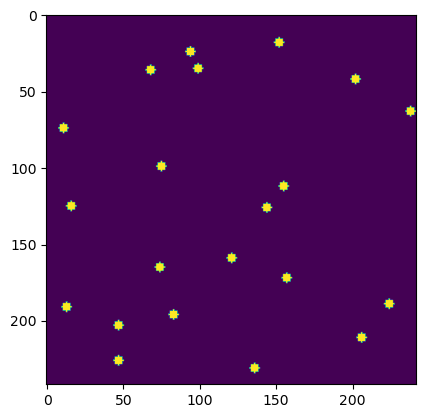

In [32]:
# morphology.diskで丸のfootprintを作成
disk = morphology.disk(radius = 3)
h_maxima_disk= morphology.binary_dilation(h_maxima, footprint=disk)
plt.imshow(h_maxima_disk)

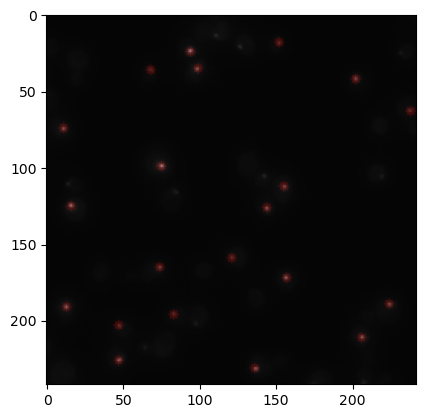

In [33]:
label_h_maxima_disk = label(h_maxima_disk)
overlay_h_disk = color.label2rgb(label_h_maxima_disk, foci*3, alpha=0.2, bg_label=0,
                          bg_color=None, colors=[(1, 0, 0)])
plt.imshow(overlay_h_disk)